# Downloading earthquake data
There are many databases online we can download earthquake data from:
* [USGS website](https://earthquake.usgs.gov/earthquakes/feed/v1.0/csv.php)
* [International Seismological Centre](http://www.isc.ac.uk/iscbulletin/search/catalogue/)
* [IRIS earthquake browser](https://ds.iris.edu/ieb/)
* [CMT catalogue](https://www.globalcmt.org/CMTsearch.html)

But what if we wanted to write our own code that downloads information on earthquakes. [ObsPy](https://github.com/obspy/obspy/wiki) library has exactly what we need to download data from [IRIS](https://www.iris.edu/hq/)!

Let's start by loading all the necessary libraries:

In [1]:
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import pandas as pd

import numpy as np

## Input parameters
At first we will specify a bunch of parameters that will be useful in choosing the earthquake data we are interested in.

### Networks and stations
We can specify particular seismograph networks and stations to be used when downloading the data. For example, we can look at [IRIS online map](http://ds.iris.edu/gmap/) that displays what networks and stations are within the region. If we want to specify either of them, we need to put a list of strings with short codes, such as 'TA' for Transportable Array network in USA and 'O20K' for a station in Alaska. In this exercise, we will want all the networks and stations, therefore we can assign 'None' to the variables:

In [2]:
network = None
station = None

### Start and end time
Usually we want to specify the time window for which we want the earthquake data downloaded. The code takes date and time in UTC format that we can use [datetime](https://docs.python.org/3/library/datetime.html) library for. The required format is:

    1970-01-01 01:01:1.01

In this example, we will specify end time to be current date and time and end time to be 10 years prior:

In [3]:
start_time = datetime.utcnow() - timedelta(days=10*365)
end_time = datetime.utcnow()

print(start_time, end_time)

2010-06-25 08:45:05.483589 2020-06-22 08:45:05.483589


### Boundaries
We may specify where should the earthquakes come from. We can either input a box boundary or central latitude and longitude and radius. In this example, we will look at a box and we will specify minimum and maximum latitude and longitude:

In [4]:
min_latitude = 55
max_latitude = 65
min_longitude = -160
max_longitude = -140

### Magnitude and depth
We can also specify the minimum and maximum magnitude and depth of the earthquakes downloaded. In this example we will set a minimum magnitude, no maximum magnitude and no depth constraints.

In [5]:
min_mag = 4.0
max_mag = None
min_depth = None
max_depth = None

## Accessing IRIS
ObsPy has many classes and functions that interact with IRIS earthquake database. The [Client](https://docs.obspy.org/master/packages/obspy.clients.iris.html) class creates a wrapper around IRIS Web services and allows you to access information from Python.

In [6]:
from obspy.clients.fdsn import Client

client = Client("IRIS")

To access earthquake catalogue we can use:

    client.get_events()
    
All keyword arguments are listed [here](https://docs.obspy.org/packages/autogen/obspy.clients.fdsn.client.Client.get_events.html).

In [7]:
catalogue = client.get_events(starttime=start_time,endtime=end_time,\
                              minlatitude=min_latitude,maxlatitude=max_latitude,\
                              minlongitude=min_longitude,maxlongitude=max_longitude,\
                              minmagnitude=min_mag, maxmagnitude=max_mag,\
                              mindepth=min_depth, maxdepth=max_depth)

print(catalogue)

1045 Event(s) in Catalog:
2020-06-18T20:38:43.301000Z | +60.887, -149.091 | 4.2 ml
2020-06-12T04:48:49.070000Z | +57.325, -155.204 | 4.4 mb
...
2010-07-11T07:07:23.870000Z | +56.743, -154.008 | 4.0 mb
2010-07-08T03:15:49.260000Z | +61.857, -150.527 | 4.7 MW
To see all events call 'print(CatalogObject.__str__(print_all=True))'


We can plot the catalogue using ObsPy built-in function to quickly look up the data:

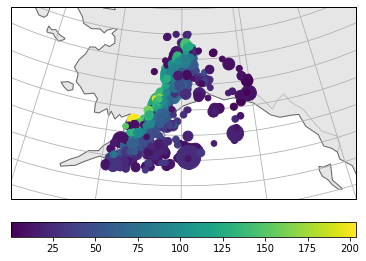

In [8]:
catalogue.plot(projection="local", label=None, method="cartopy", title="")
plt.show()

The catalogue states that we have over 1000 events recorded by IRIS for given parameters. Now we will want to access the data in the catalogue. 

[<img src="https://docs.obspy.org/_images/Event.png" style="width:600px;"/>](https://docs.obspy.org/packages/obspy.core.event.html)



If we loop over elements, or _events_ in the Catalogue we can access different information. Below we will extract origin time of the earthquake, its location, depth and magnitude:

In [9]:
# Create empty lists
year = []
month = []
day = []
hour = []
minute = []
second = []

lat = []
lon = []
dep = []
mag = []
time = []

# Loop over each event in the catalogue
for event in catalogue:
    
    year.append(event.origins[0].time.year)
    month.append(event.origins[0].time.month)
    day.append(event.origins[0].time.day)
    hour.append(event.origins[0].time.hour)
    minute.append(event.origins[0].time.minute)
    second.append(event.origins[0].time.second)

    lat.append(event.origins[0].latitude)
    lon.append(event.origins[0].longitude)
    dep.append(event.origins[0].depth/1000.)
    mag.append(event.magnitudes[0].mag)


## Custom data plotting
For custom plotting, we can create a pandas DataFrame with all the information on earthquakes:

In [10]:
data = pd.DataFrame(np.array([year, month, day, hour, minute, second, lat, lon, dep, mag]).T, 
             columns=["year", "month", "day", "hour", "minute", "second",
                      "lat", "lon", "depth_m", "mag"])

data.head(3)

,year,month,day,hour,minute,second,lat,lon,depth_m,mag
0,2020.0,6.0,18.0,20.0,38.0,43.0,60.8874,-149.0910,26.3,4.2
1,2020.0,6.0,12.0,4.0,48.0,49.0,57.3254,-155.2038,49.1,4.4
2,2020.0,6.0,8.0,18.0,57.0,5.0,56.0446,-153.7615,29.9,4.0


Code below will plot the downloaded earthquakes on a map:

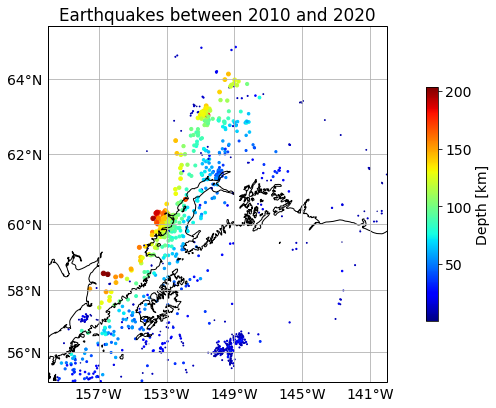

In [11]:
plt.rcParams.update({'font.size': 14})

central_lon = min_longitude
central_lat = min_latitude

extent = [min_longitude,max_longitude,min_latitude,max_latitude]

fig, ax = plt.subplots(1, subplot_kw=dict(projection=ccrs.Mercator(central_lon, central_lat)), figsize=(7,7))

ax.set_extent(extent)
ax.coastlines(resolution='10m')

plt.title("Earthquakes between %g and %g" % (np.min(data.year), np.max(data.year)))

# Create a scatter plot
scatplot = ax.scatter(data.lon, data.lat, c=data.depth_m,
                      s=data.depth_m/10, cmap="jet",
                      transform=ccrs.Geodetic())

# Create colourbar
cbar = plt.colorbar(scatplot, ax=ax, fraction=0.03, pad=0.1, label='Depth [km]')

# Sort out gridlines and their density
xticks_extent = list(np.arange(min_longitude-5, max_longitude+5, 4))
yticks_extent = list(np.arange(min_latitude-3, max_latitude+3, 2))

gl = ax.gridlines(linewidths=0.1)
gl.xlabels_top = False
gl.xlabels_bottom = True
gl.ylabels_left = True
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator(xticks_extent)
gl.ylocator = mticker.FixedLocator(yticks_extent)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

plt.show()

Here we can plot a histogram of earthquake magnitudes:

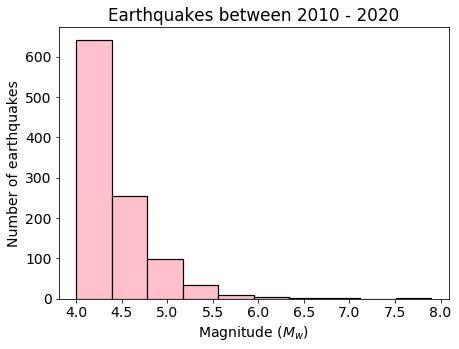

In [12]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(7,5))

plt.title('Earthquakes between %g - %g' % (np.min(data.year), np.max(data.year)))
n,bins,patches = plt.hist(data.mag, color='pink',edgecolor='black', linewidth=1.2)

plt.xlabel('Magnitude ($M_w$)')
plt.ylabel('Number of earthquakes')

plt.show()